### imports

In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import log10, floor

### Function Definitions

In [2]:
def LorentzBeta(gamma):
    return np.sqrt( 1. - (1./gamma**2) )

In [3]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [4]:
# Function to print lines between min_ and max_ values
def print_some_lines(line_list, min_, max_):
    j = 0
    for i in line_list:
        if (j <= max_) and (j >= min_):
            print i
        j = j + 1
    return

print_all_lines = lambda x: sys.stdout.write("\n".join(x) + "\n")


# PTC-PyORBIT Examples: Create a PTC Flat File using a MAD-X lattice description

We obtain our accelerator lattice definition in MAD-X format from the CERN BE-ABP maintained acc-models GitLab repository: https://gitlab.cern.ch/acc-models

Each machine has its own repository. Please make sure to use the latest lattice relevent to your specific requirements.

## Step 1: RF Cavity definition modification: no_cavity_totalpath flag

The first thing we must to is check/edit lattice settings that will create an unusable PTC flat file.

We must use the no_cavity_totalpath flag and set used RF cavity lengths to 1.0 m. In this case all RF cavities are removed in the PS_Lattice/remove_elements.seq file, so we only edit one line.

In [5]:
# Open the file with read only permit
harmonic7_sequence_file = open('PS_Lattice/ps_ss_h7.seq', "r")

# use readlines to read all lines in the file
# The variable "harmonic7_sequence_lines" is a list containing all lines in the file
harmonic7_sequence_lines = harmonic7_sequence_file.readlines()

# close the file after reading the lines
harmonic7_sequence_file.close()

We replace line 78:

In [6]:
print harmonic7_sequence_lines[77]

!ACC10     : RFCAVITY    , L := 2.45;      ! 10 MHz radio frequency cavity



With:

In [7]:
print harmonic7_sequence_lines[78]

ACC10     : RFCAVITY    , L := 1.0, LAG=0, HARMON=7, no_cavity_totalpath; ! Fix for PTC PyORBIT SC sims



The specific cavity used is defined in line 161:

In [8]:
print harmonic7_sequence_lines[160]

 PA.C10.11      : ACC10     , AT = 1.509, SLOT_ID = 2253478;



Note that as we have a harmonic 9 sequence file (PS_Lattice/ps_ss_h9.seq) this step is repeated for that file also.

## Step 2: MAD-X Setup

Our MAD-X simulation is defined using the Create_PTC_flat_file.madx script.

Brief file description:

In [9]:
madx_simulation_file = open('Create_PTC_flat_file.madx', "r")
madx_simulation_lines = madx_simulation_file.readlines()
madx_simulation_file.close()

In [10]:
print_some_lines(madx_simulation_lines, 0, 24)

TITLE, "Flat file generation for PTC-PyORBIT";

/***********************************************************************

 *                  CERN Proton Synchrotron: Injection

 *        Create PTC Flat File for PTC-PyORBIT lattice definition

 *

 * Last Edit: 11.06.20 Haroon Rafique CERN BE-ABP-HSI

 **********************************************************************/





/***********************************************************************

 *                       USER SETTINGS FLAGS

 *

 *      Here we have the necessary files and macros for:

 *      ------------------------------------------------

 *      - Run2 and Run3, LHC BCMS and Standard beams.

 *      - PS Injection settings NOT including injection bump.

 *      - Addition of single or distributed quadrupolar error.

 *      - Matching of tunes using Low Energy Quadrupoles (LEQs) or 

 *        Pole Face Windings (PFWs).

 *      - Matching of chromaticity using PFWs.

 *      - Changing the lattice start posi

***
In this example we will use the Run 3 (LIU) Standard (harmonic = 7) beam, with no errors, using the bare machine tune and chromaticity. This is set using the flags in the next part of Create_PTC_flat_file.madx

In [11]:
print_some_lines(madx_simulation_lines, 25, 35)

quad_error = 0;	                ! Add quadrupolar error on QDN72

distributed_quad_error = 0;	! Add quadrupolar error on all QDNs



match_tunes = 0;                ! Match tunes to values in tunes.str

use_pfw = 0;	                ! Match tunes with PFW (1) or LEQ (0)

match_chroma = 0;               ! Match chromaticity to given values



BCMS = 0;		!Harmonic 9 for BCMS, 7 for Standard LHC beams

LIU = 0;		!LIU (1) KE = 2GeV, pre-LIU (0) KE = 1.4GeV



start_lattice_marker = 0;



# Step 3: Run MAD-X 
- running this way will save the output to the file madx_output_toscreen.txt

In [12]:
os.system('./clean_run.sh')
madx_command = '../madx-linux64_v5_02_00 < Create_PTC_flat_file.madx > madx_output_toscreen.txt'
os.system(madx_command)

0

# Step 4: Plot optics from MAD-X and PTC

In [13]:
########################################################################
# Read PTC Twiss and return dictionary of columns/values
########################################################################
def Read_PTC_Twiss_Return_Dict(filename, verbose=True):
    # Dictionary for output
    d = dict()
    d['HEADER_FILENAME'] = filename
    keywords = ''
    
    # First we open and count header lines
    fin0=open(filename,'r').readlines()
    headerlines = 0
    for l in fin0:
        # Store each header line
        headerlines = headerlines + 1
        # Stop if we find the line starting '* NAME'
        if '* NAME' in l:
            keywords = l
            break
        # Store the headers as d['HEADER_<name>'] = <value>
        else:
            #try:
            #    d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]     
            #except ValueError:
            #    d[str('HEADER_'+l.split()[1])]=[str(l.split()[-1])]   
            if '"' in l:
                d[str('HEADER_'+l.split()[1])]=[str(l.split('"')[1])]
            else:
                d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]                 
    headerlines = headerlines + 1    
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict found Keywords: \n',keywords
    
    # Make a list of column keywords to return (as an aid to iterating)
    dict_keys = []
    for key in keywords.split():
        dict_keys.append(key)
    dict_keys.remove('*')
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict Dict Keys: \n',dict_keys
    
    # Initialise empty dictionary entries for column keywords 
    for key in dict_keys:
        d[key]=[]
        
    if verbose: print '\nRead_PTC_Twiss_Return_Dict header only dictionary \n', d
    
    # Strip header
    fin1=open(filename,'r').readlines()[headerlines:]   
    
    # Populate the dictionary line by line
    for l in fin1:
        i = -1        
        for value in l.split():
            i = i+1
            if 'NAME' in dict_keys[i]:
                d[dict_keys[i]].append(str(value))
            else:
                d[dict_keys[i]].append(float(value))    
                
    # Return list of column keywords 'dict_keys', and dictionary 'd'
    return dict_keys, d

In [14]:
d_keys, d = Read_PTC_Twiss_Return_Dict('optimised_flat_file.tfs', verbose=True)


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 
{'HEADER_ETA_C': [-0.1342204838], 'HEADER_TCOMIN': [0.0], 'HEADER_BETA11MIN': [11.57151266], 'HEADER_DELTAP': [0.0], 'HEADER_BETA33MIN': [0.0], 'HEADER_TCOMAX': [0.0], 'HEADER_PC': [2.14], 'HEADER_BETA22MAX': [23.63949582], 'HEADER_BETA12MIN': [0.0], 'HEADER_ALPHA_C': [0.02701793732], 'HEADER_BETA_X_MAX': [23.1637637], 'HEADER_BETA_X_MIN': [11.57151266], 'HEADER_ALPHA_C_P2': [-1000000.0], 'HEADER_ALPHA_C_P3': [-1000000.0], 'HEADER_BE

In [15]:
# Labels given by TFS table column headers
d_keys

['NAME',
 'S',
 'BETX',
 'BETY',
 'ALFX',
 'ALFY',
 'DISP1',
 'DISP2',
 'DISP3',
 'DISP4',
 'MU1',
 'MU2',
 'X',
 'PX',
 'Y',
 'PY']

In [16]:
# Tune
print 'Fractional tunes = (', round_sig(d['HEADER_Q1'][0]), ',' , round_sig(d['HEADER_Q2'][0]), ')'

Fractional tunes = ( 0.21 , 0.245 )


In [17]:
# Tune
print 'Relativistic Gamma = ', round_sig(d['HEADER_GAMMA'][0])
relativistic_beta_ptc = LorentzBeta(d['HEADER_GAMMA'][0])
print 'Relativistic Beta = ', round_sig(relativistic_beta_ptc)

Relativistic Gamma =  2.49
Relativistic Beta =  0.916


In [18]:
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['lines.linewidth'] = 1.5

save_folder = 'Plots'

legend_label = 'Case'
main_label = 'PS_PTC_Twiss'

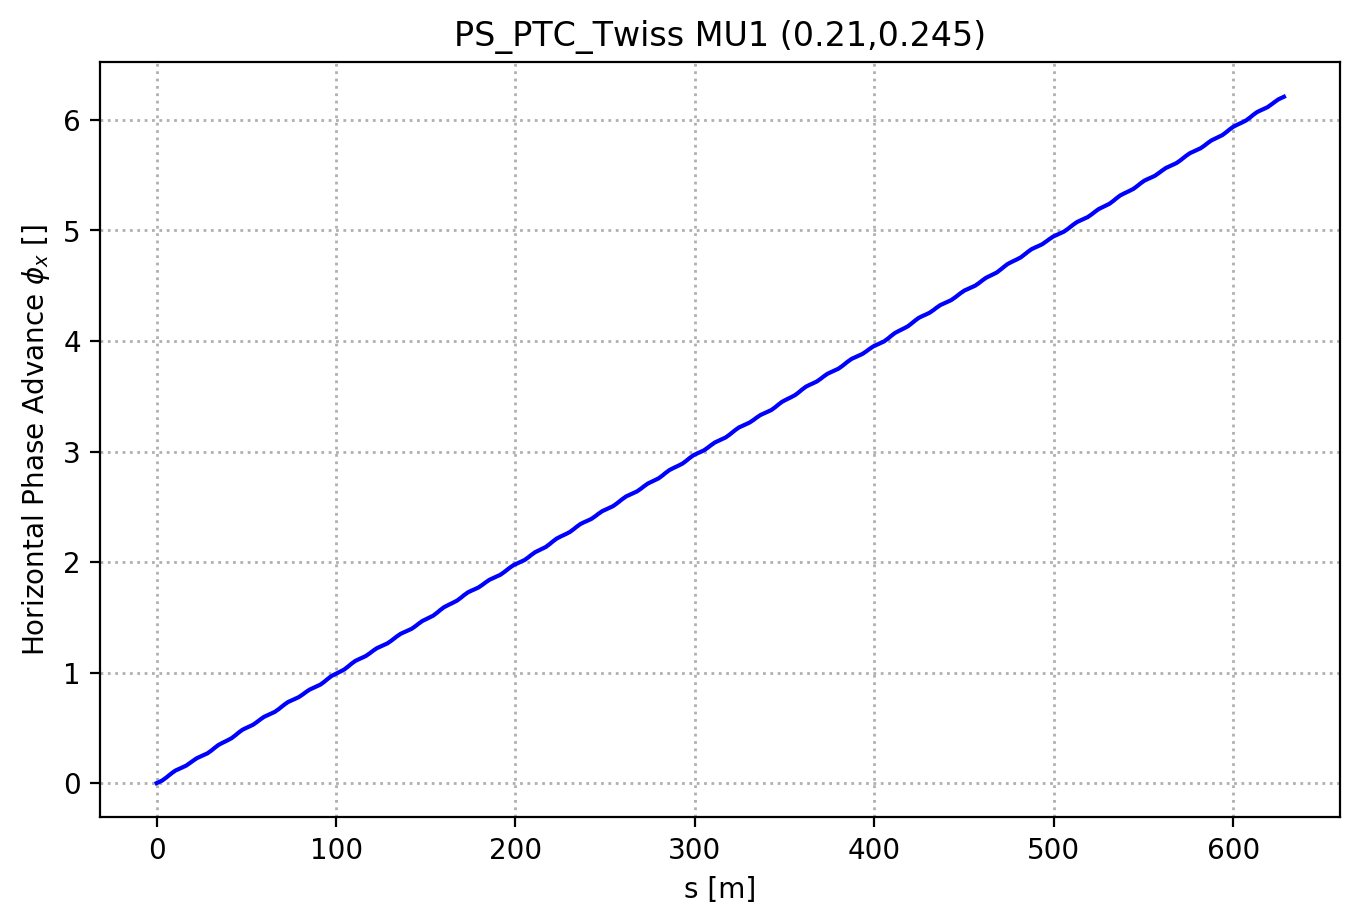

In [19]:
parameter = 'MU1'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'

ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'Horizontal Phase Advance $\phi_x$ []');

ax1.plot(d['S'], d[parameter], label='', color='b');
   
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

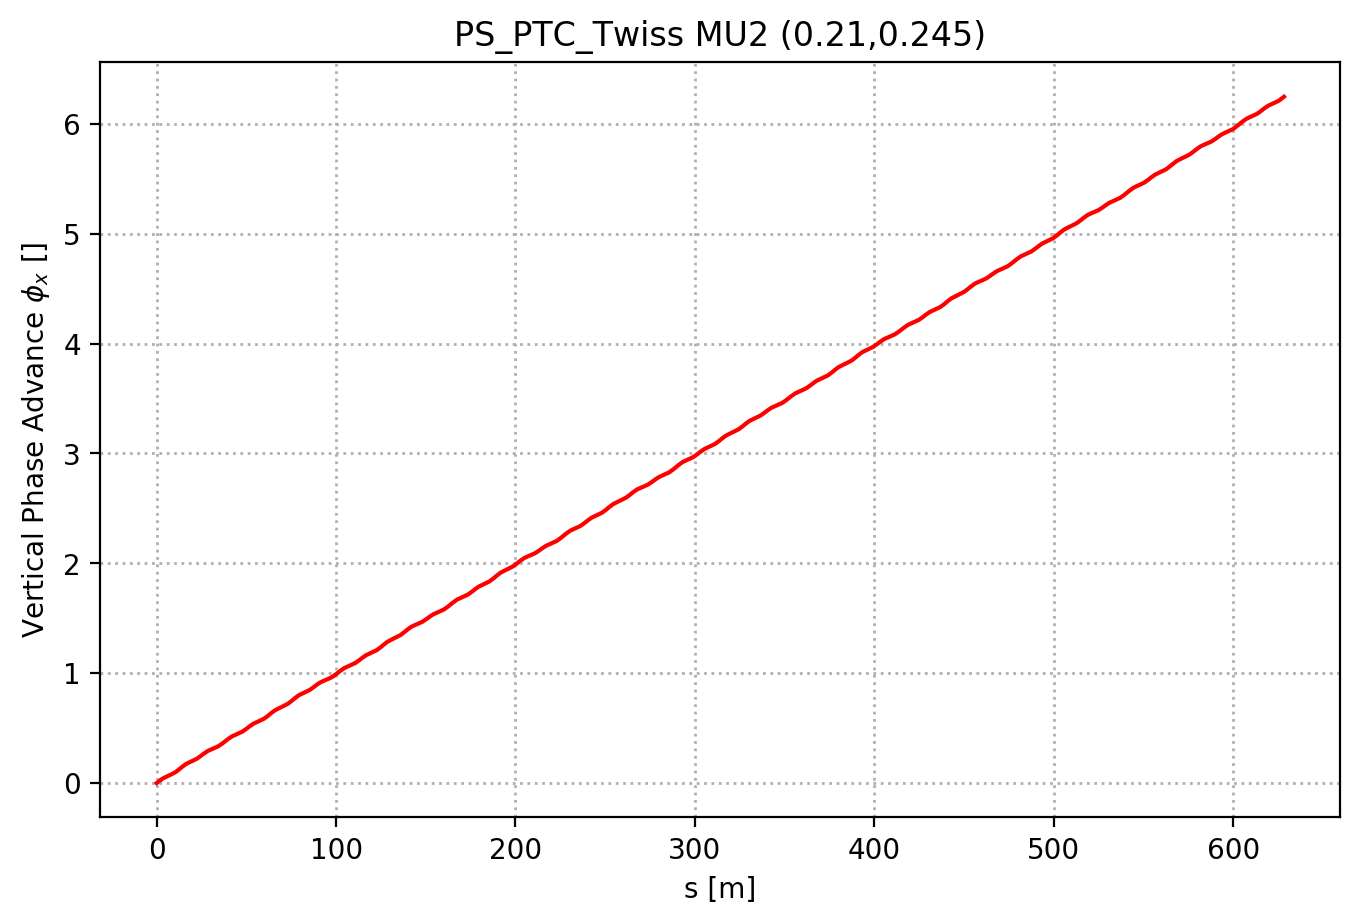

In [20]:
parameter = 'MU2'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'Vertical Phase Advance $\phi_x$ []');

ax1.plot(d['S'], d[parameter], label='', color='r');
   
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

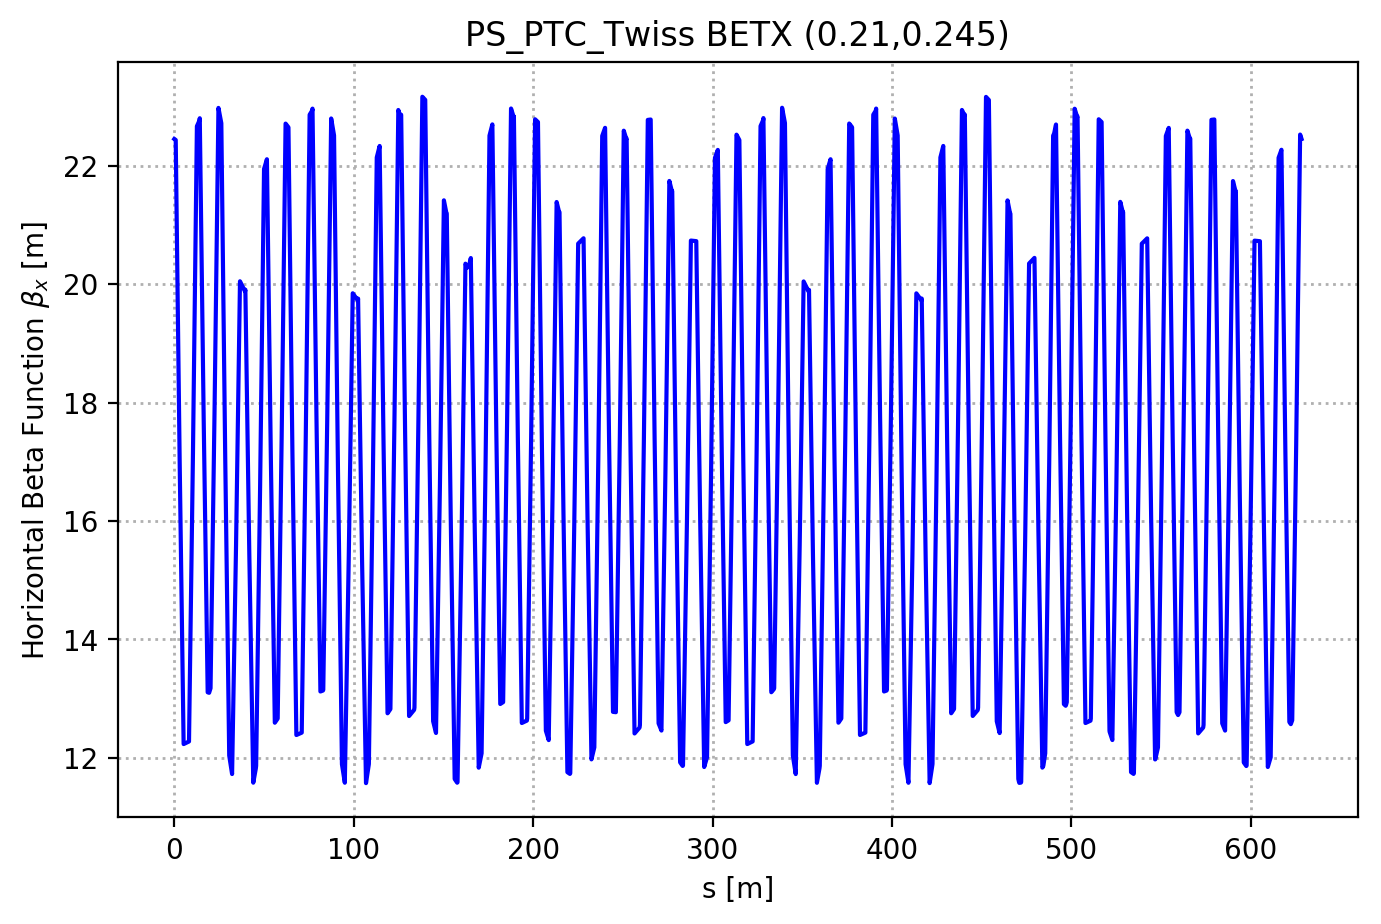

In [21]:
parameter = 'BETX'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'Horizontal Beta Function $\beta_x$ [m]');

ax1.plot(d['S'], d[parameter], label='', color='b');
       
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

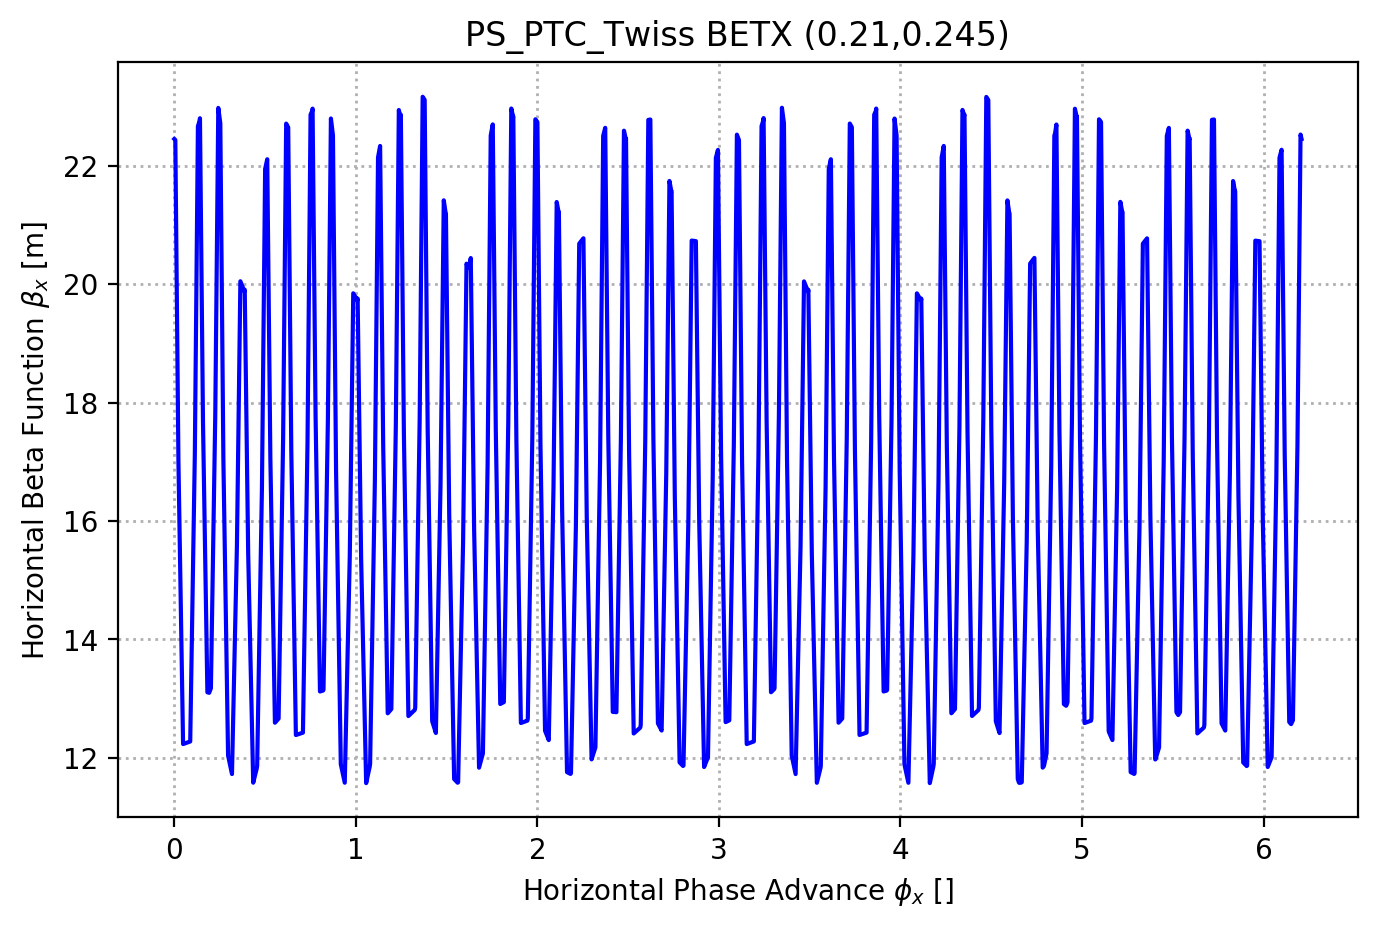

In [22]:
parameter = 'BETX'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);


ax1.set_xlabel(r'Horizontal Phase Advance $\phi_x$ []');
ax1.set_ylabel(r'Horizontal Beta Function $\beta_x$ [m]');

ax1.plot(d['MU1'], d[parameter], label='', color='b');
       
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '_phase_advance.png'
plt.savefig(savename, dpi = 200);

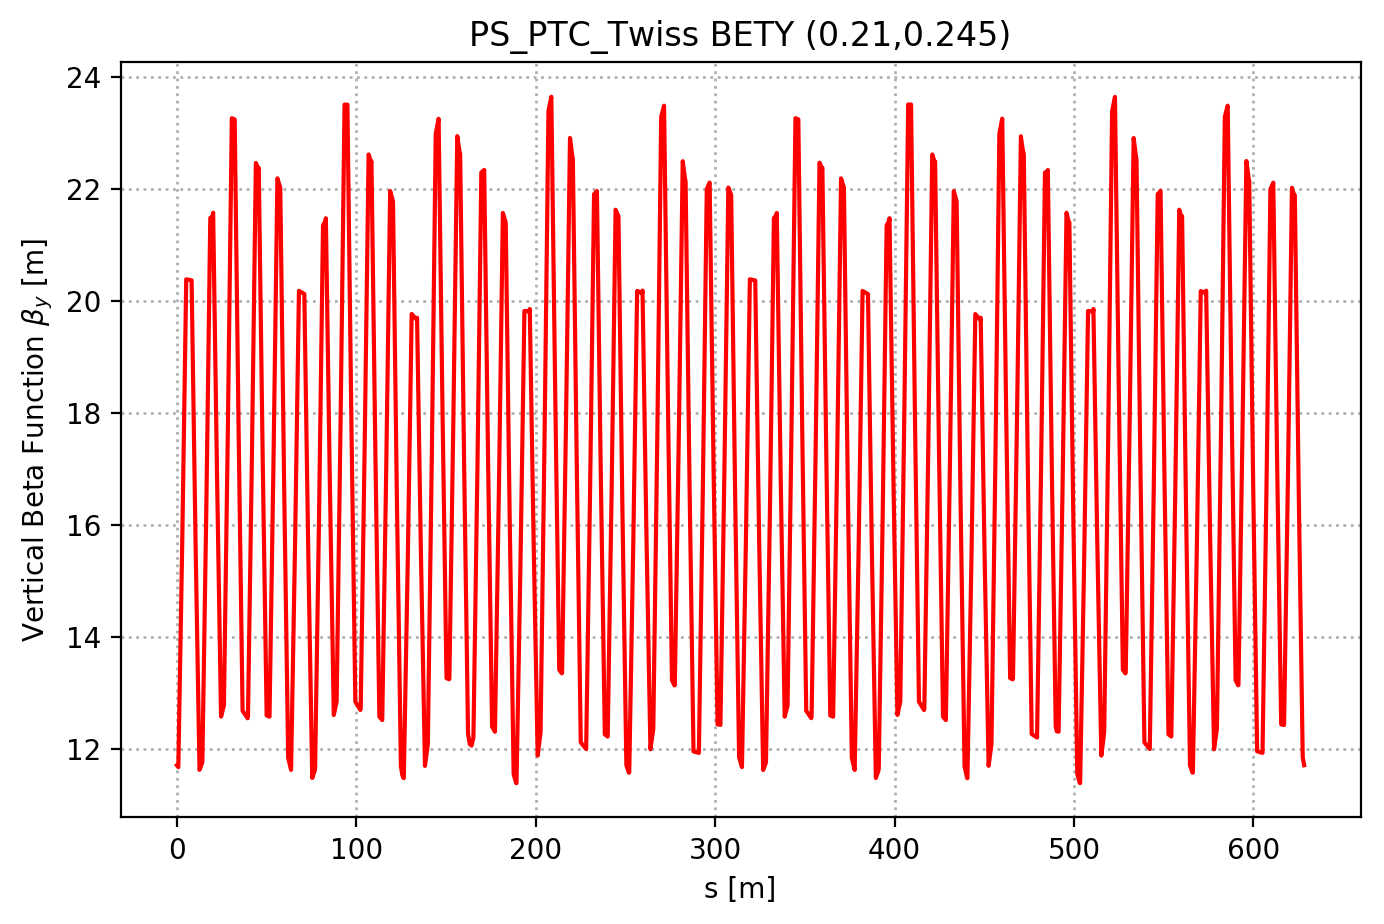

In [23]:
parameter = 'BETY'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'Vertical Beta Function $\beta_y$ [m]');

ax1.plot(d['S'], d[parameter], label='', color='r');
       
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

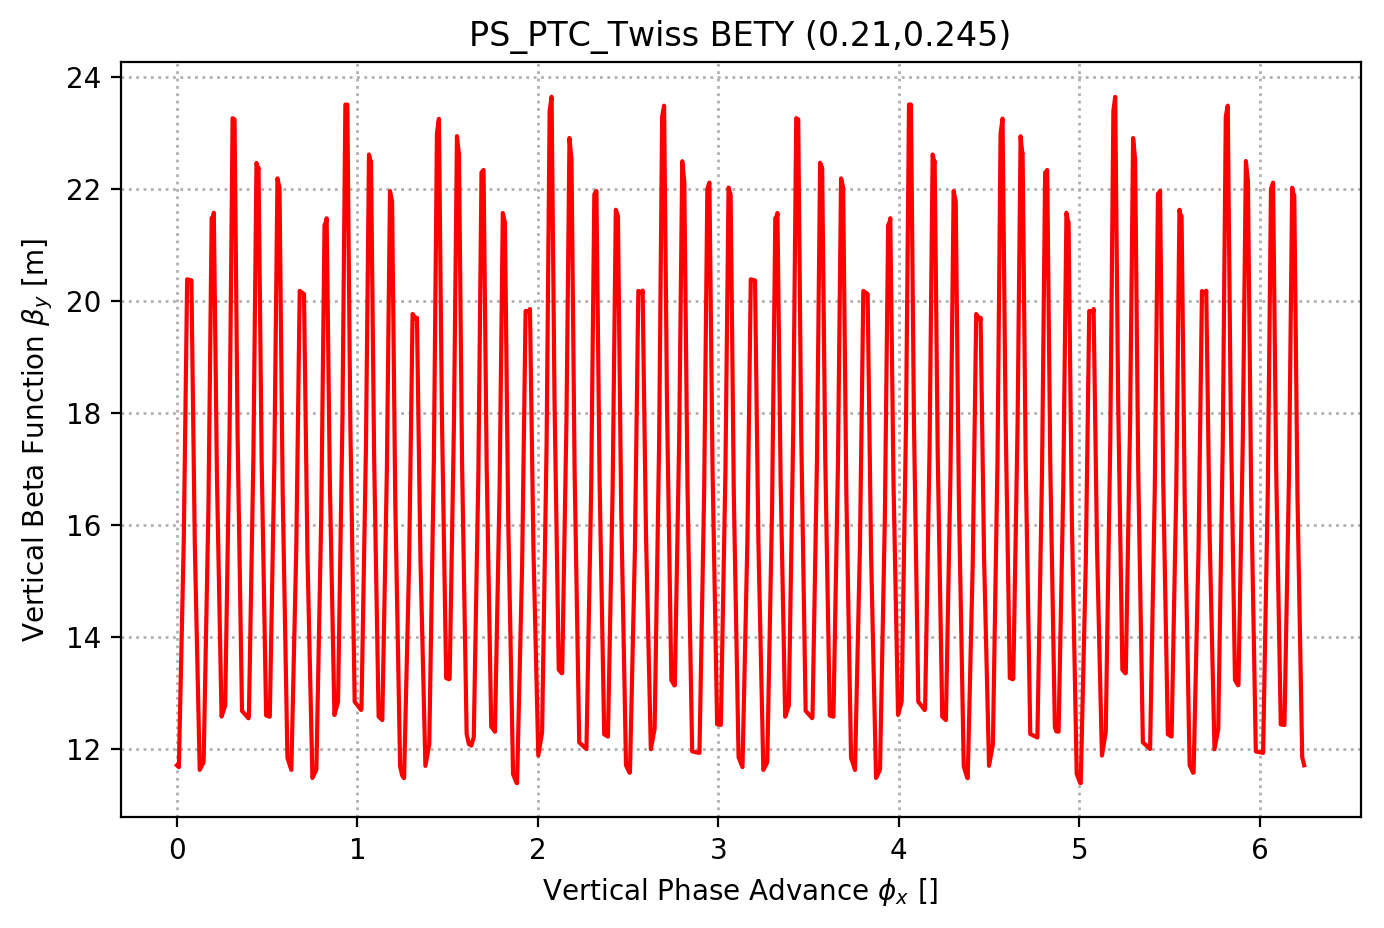

In [24]:
parameter = 'BETY'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);

ax1.set_xlabel(r'Vertical Phase Advance $\phi_x$ []');
ax1.set_ylabel(r'Vertical Beta Function $\beta_y$ [m]');

ax1.plot(d['MU2'], d[parameter], label='', color='r');
       
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '_phase_advance.png'
plt.savefig(savename, dpi = 200);

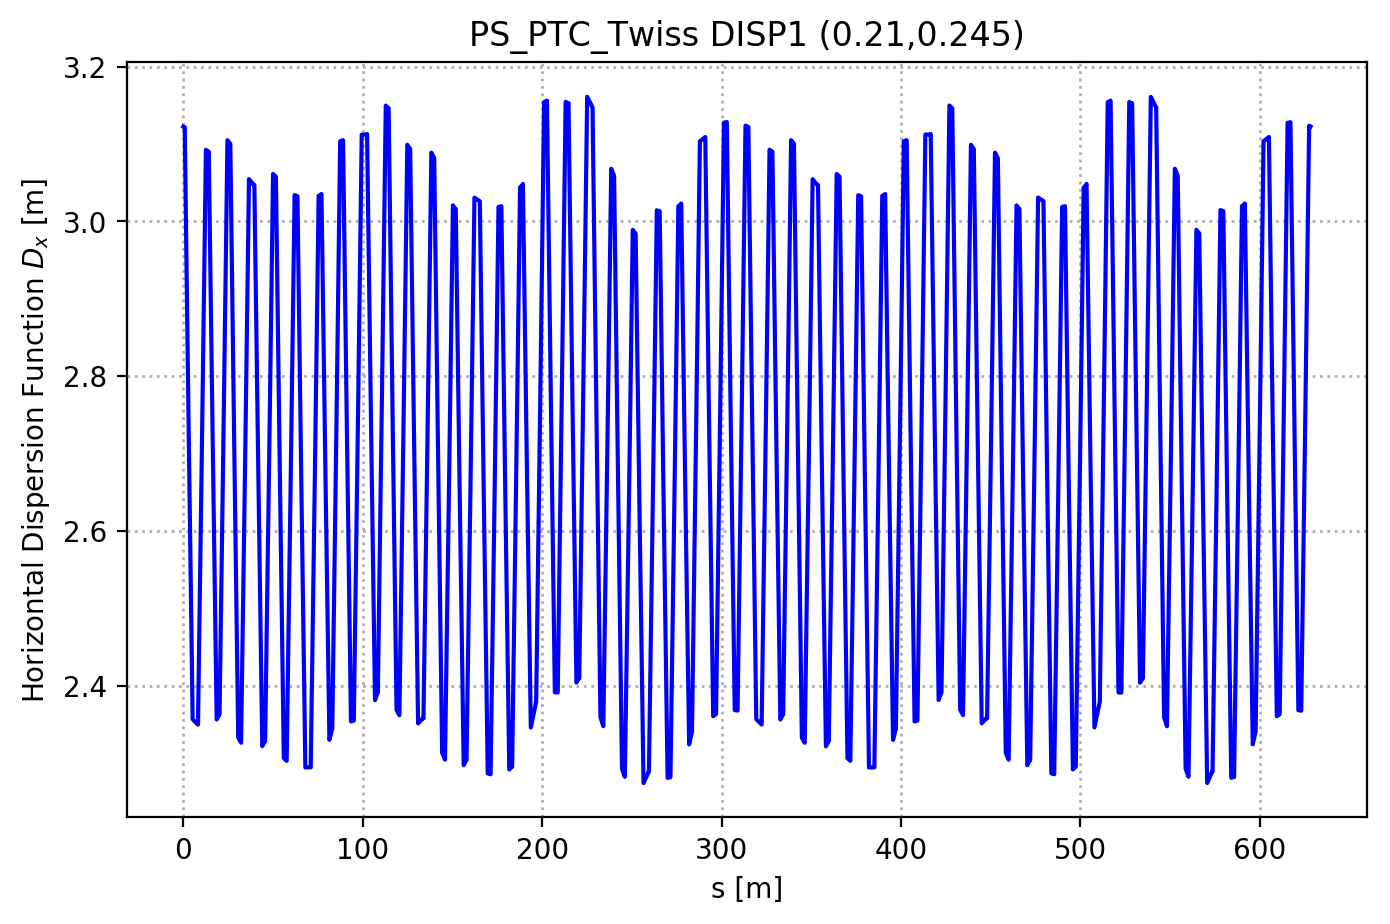

In [25]:
parameter = 'DISP1'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'Horizontal Dispersion Function $D_x$ [m]');

ax1.plot(d['S'], np.array(d[parameter])*relativistic_beta_ptc, label='', color='b');
       
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

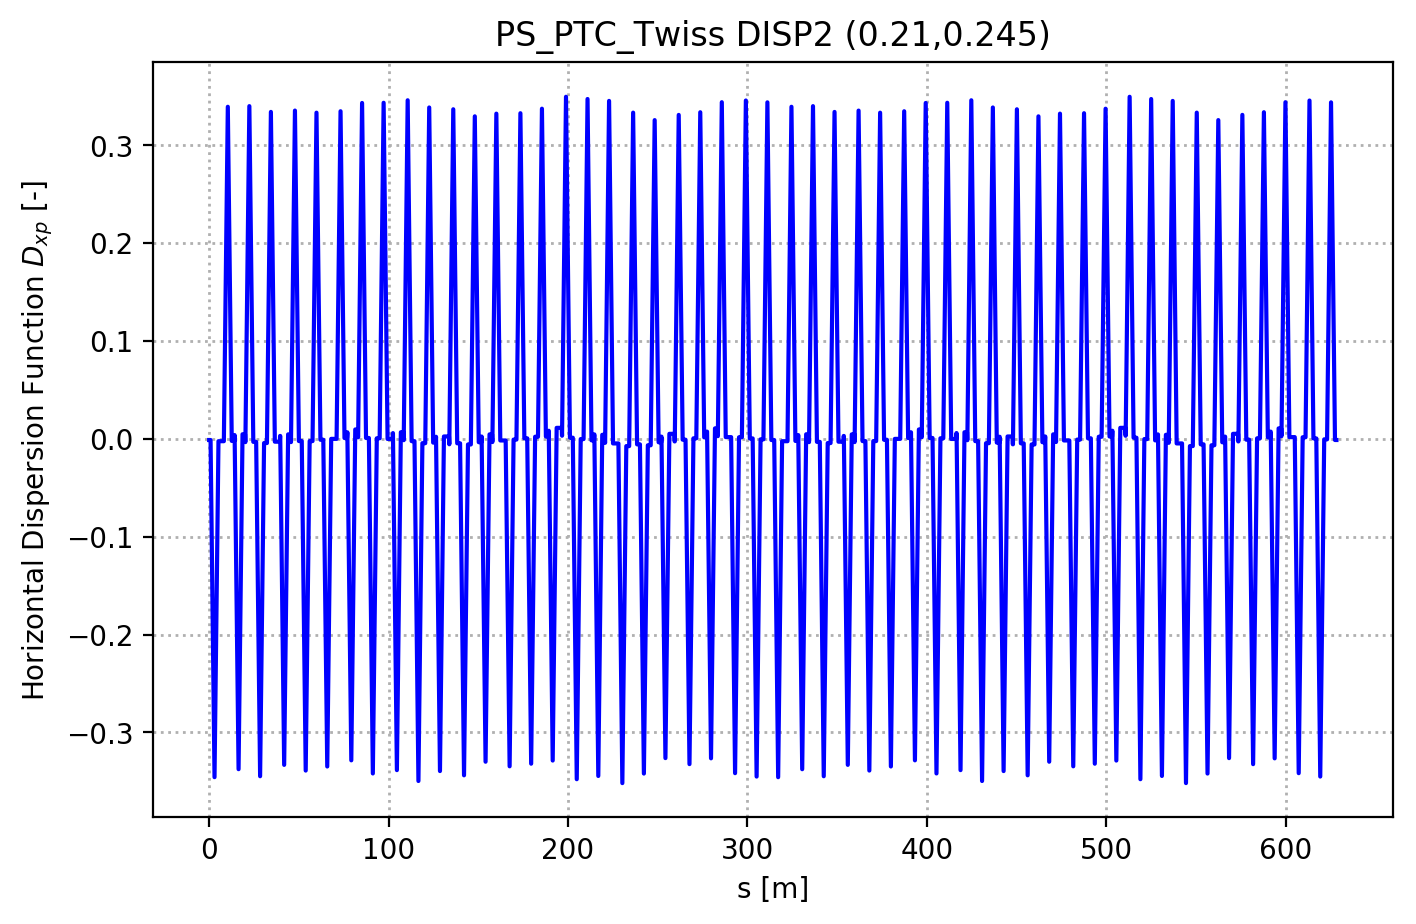

In [26]:
parameter = 'DISP2'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'Horizontal Dispersion Function $D_{xp}$ [-]');

ax1.plot(d['S'], np.array(d[parameter])*relativistic_beta_ptc, label='', color='b');
       
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

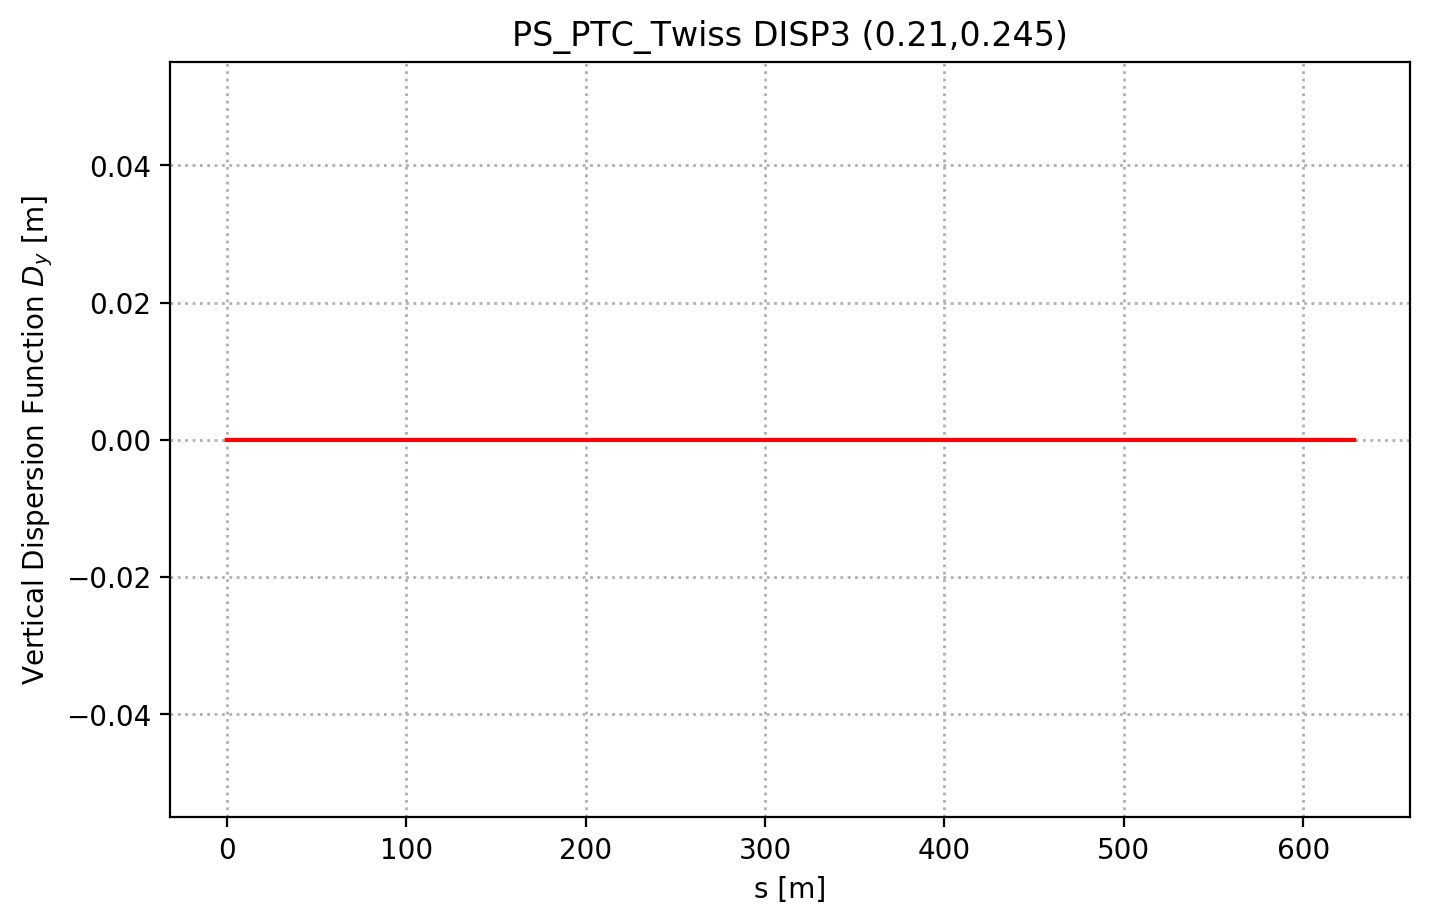

In [27]:
parameter = 'DISP3'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'Vertical Dispersion Function $D_y$ [m]');

ax1.plot(d['S'], np.array(d[parameter])*relativistic_beta_ptc, label='', color='r');
       
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

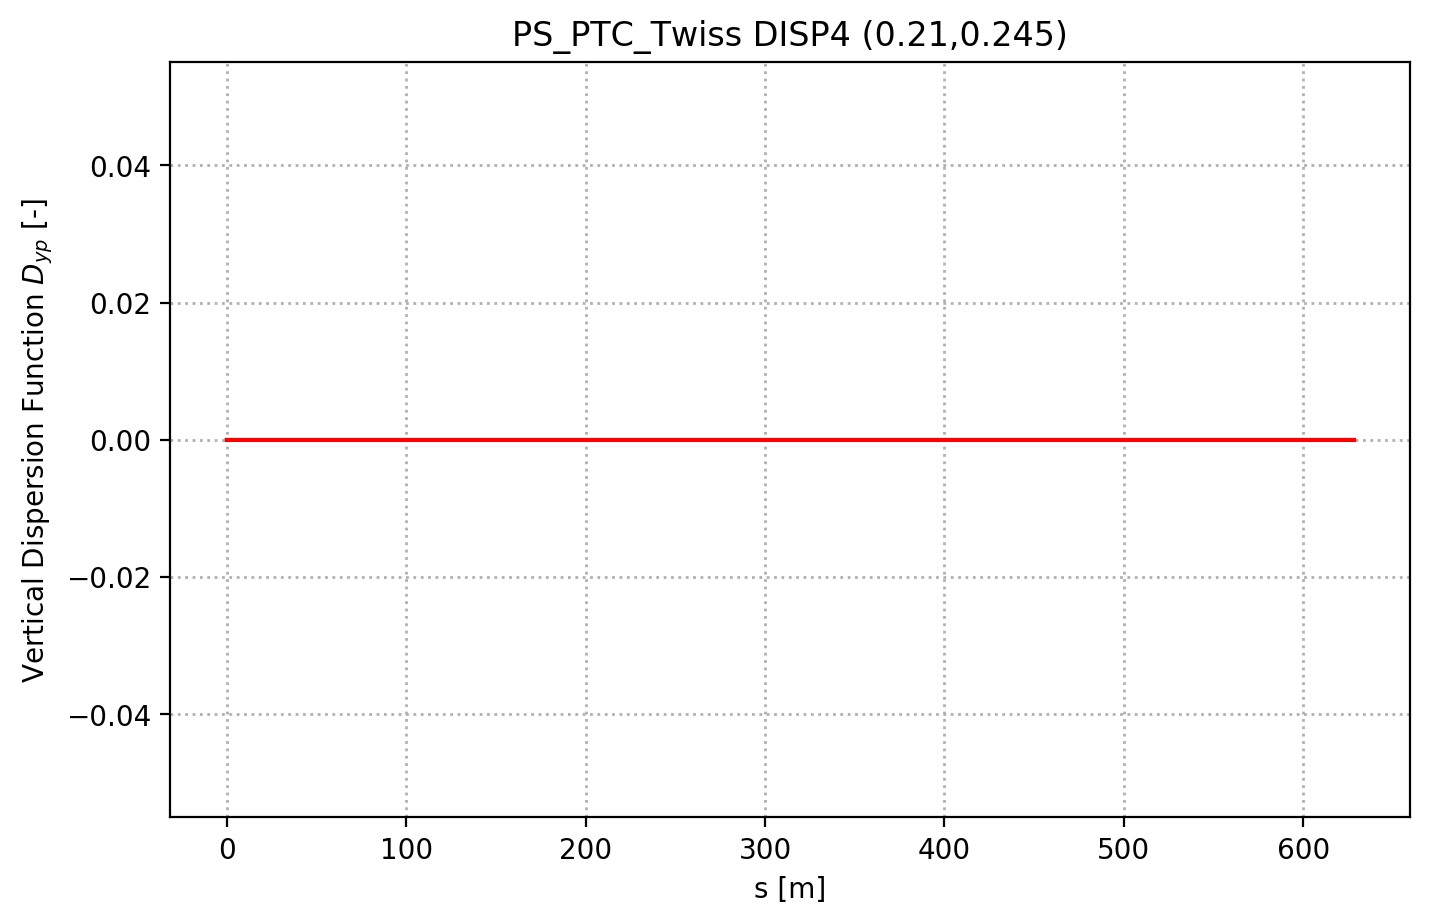

In [28]:
parameter = 'DISP4'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'Vertical Dispersion Function $D_{yp}$ [-]');

ax1.plot(d['S'], np.array(d[parameter])*relativistic_beta_ptc, label='', color='r');
       
#ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

# Check PTC Flat File

In [29]:
ptc_flat_file2 = open('PTC-PyORBIT_flat_file.flt', "r")
ptc_flat_file_lines = ptc_flat_file2.readlines()
ptc_flat_file2.close()

In [30]:
print_some_lines(ptc_flat_file_lines, 0, 8)

        1129  0.500000000000000       NUMBER OF FIBRES AND L_MAX  

 GLOBAL DATA FOR No name assigned

  0.938272013000000        2.14000001446868        1.79284735000000      MASS, P0C, AG(spin)                                                                                                                                                                   

  -3.14159265358979      T   1.00000000000000      PHASE0, compute_stoch_kick, CHARGE                                                                                                                                                                          

           1 T T CAVITY_TOTALPATH,ALWAYS_EXACTMIS,ALWAYS_EXACT_PATCHING

          10           5 T           2 SECTOR_NMUL_MAX,SECTOR_NMUL,OLD_IMPLEMENTATION_OF_SIXTRACK,HIGHEST_FRINGE                                                                                                                                               

   1.25000000000000        1.50000000000000      F we

# Conclusion

- If MAD-X has run correctly the file 'PTC-PyORBIT_flat_file.flt' should have been created.
- This file is our PTC flat file, an accelerator description file read by PTC-PyORBIT.
- Space charge simulations are time consuming, this can be dependent on many factors. The number of fibres, shown here to be 1129, is one of these factors. The number of fibres are proportional to the number of elements to be tracked through.
- L_Max is another important factor as it defines the maximum allowed distance between PyORBIT space charge nodes. It may be modified in the files PTC/print_flat_file.ptc and PTC/resplit.ptc.
- One may change the PTC parameters in the MAD-X simulation script 'Create_PTC_flat_file.madx' to attempt to optimise the lattice description complexity (and therefore simulation run time), this has already been done using the parameters included in the script, shown below:

In [31]:
print_some_lines(madx_simulation_lines, 90, 128)

 * PTC TWISS - output of beam dynamics parameters for each element in a 

 * PTC 'Twiss Table'. Note this is not the same as a MAD-X Twiss.

 **********************************************************************/

! PTC integration parameters



propagation_method = 2; 

order_of_integrator = 6;



! propagation_method 1: Drift-Kick-Drift

! 2 = 2nd order, one kick per integration step, naive.

! 4 = Ruth-Neri-Yoshida 4th order method, 3 kicks per integration step.

! 6 = Yoshida 6th order method, 7 kicks per integration step.



! propagation_method 2: Matrix-Kick-Matrix

! 2 = Euler-like Matrix-Kick-Matrix

! 4 = Simpson-like (1/6)K-M-(2/3)K-M-(1/6)K

! 6 = Bode-like (7/90)K-M-(32/90)K-M-(12/90)K-M-(32/90)K-M-(7/90)K



! exact = true ensures SBENDs orbit is correct

! avoids quadrupole feed-down effects leading to closed orbit distortions

exact_flag = true;



! time=true: every derivative wrt dp/p needs to be multiplied by the relativistic beta DQ1, DISP1,...) required for flat f

## An important note: 
- The ptc_create_layout command must be declared with time=true for PTC flat file generation
- As we have used the ptc twiss created with the flat file, we have re-normalised every derivative wrt dp/p with the relativistic beta (i.e. dispersion values from this PTC Twiss table must be multiplied by the Lorentz beta)

In [32]:
d_keys, d2 = Read_PTC_Twiss_Return_Dict('optimised_bare_simplified.tfs', verbose=False)

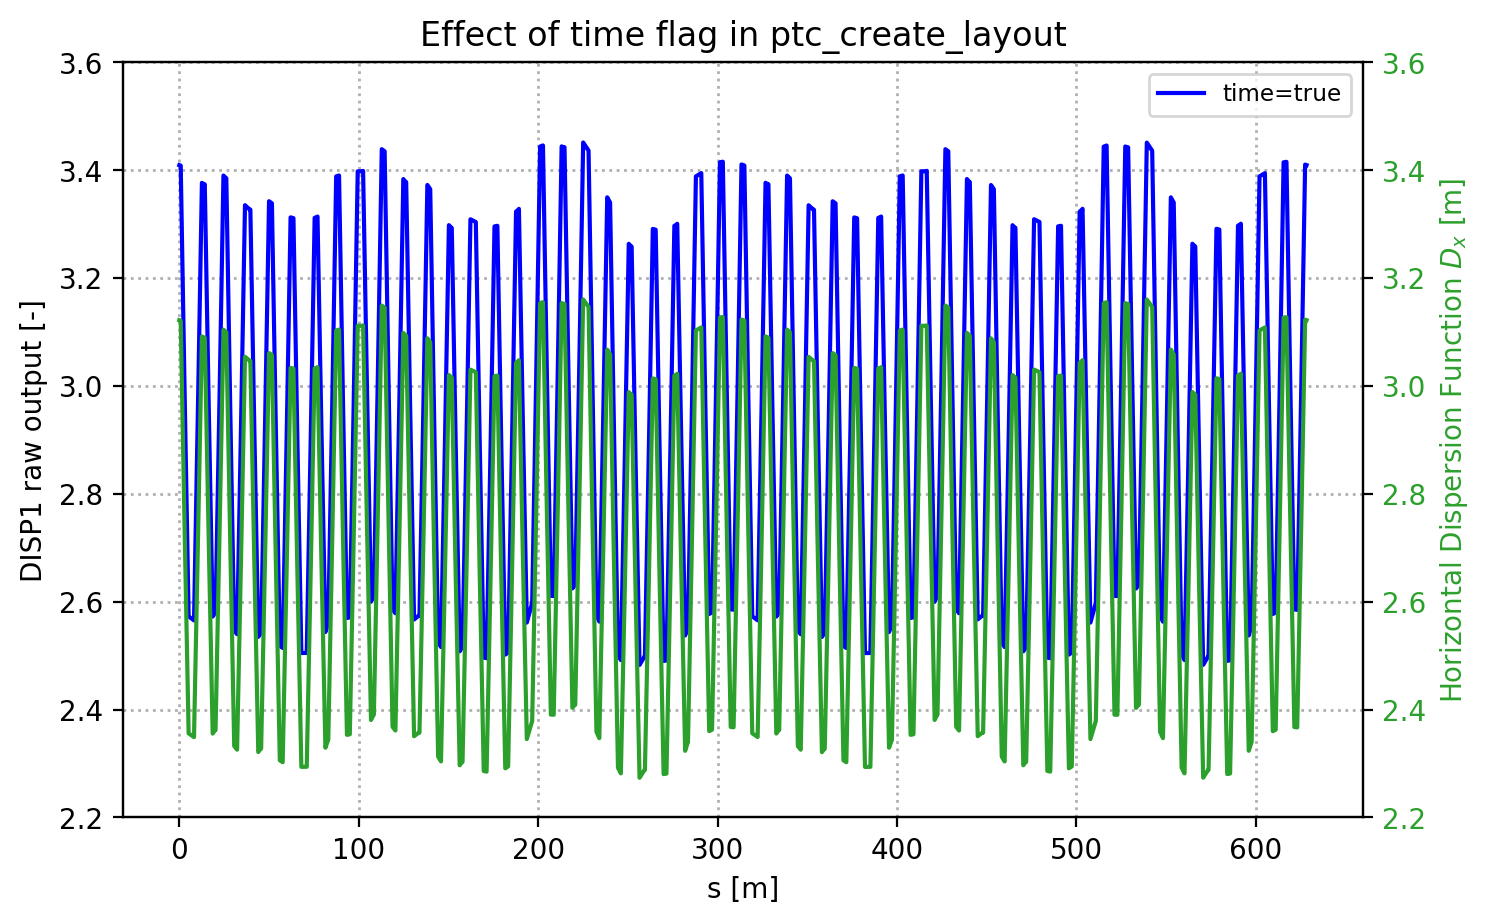

In [35]:
parameter = 'DISP1'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter + ' (' + str(round_sig(d['HEADER_Q1'][0])) + ',' + str(round_sig(d['HEADER_Q2'][0])) + ')'
ax1.set_title('Effect of time flag in ptc_create_layout');

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'DISP1 raw output [-]');

ax1.plot(d['S'], np.array(d[parameter]), label='time=true', color='b');
#ax1.plot(d2['S'], np.array(d2[parameter]), label='time=false (correct without normalisation)', color='g');
       
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel(r'Horizontal Dispersion Function $D_x$ [m]', color=color)  # we already handled the x-label with ax1
ax2.plot(d2['S'], np.array(d2[parameter]), label='time=false (correct without normalisation)', color=color);
ax2.tick_params(axis='y', labelcolor=color)
   
    
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(2.2, 3.6)
ax2.set_ylim(2.2, 3.6)

savename = save_folder + '/'+ main_label + '_' + parameter + '_ptc_create_layout.png'
plt.savefig(savename, dpi = 200);